# COVID-19's $R_t$ の推定
Kevin Systrom - April 17 (訳: DeepL)

どのような伝染病においても、$R_t$(有効再生産数)は指標となる。これは、時刻 𝑡 における感染者一人当たりの感染者数である。最もよく知られているのは、𝑡=0のときの基本的な繁殖数である$R_0$であるが、$R_0$は、行動や制限の変化に適応しない一定の尺度である。

パンデミックの進化に伴って、制限の増加（または制限の潜在的な解放）が変化する 𝑅𝑡 . 現在の「𝑅𝑡」を知ることは必須である。𝑅≫1 の場合、パンデミックは人口の大部分を伝染させる。𝑅𝑡<1の場合、パンデミックは多くの人に感染する前に急速に遅れる。𝑅𝑡：低ければ低いほど、管理しやすい状況になる。一般的には、任意の 𝑅𝑡<1 は、物事がコントロールされていることを意味する。

𝑅𝑡 の値 は、次の2つの点で私たちを助けてくれる。(1) 自分たちの対策がどれだけ効果的にアウトブレイクを抑制できているかを理解するのに役立ち、(2) 経済的繁栄と人命の安全という相反する目標に基づいて、規制を増やすべきか減らすべきかについての重要な情報を得ることができる。よく知られている疫学者は、𝑅𝑡 がこの危機を乗り切る唯一の方法である。

それなのに、今日ではまだ、𝑅𝑡 というような形で。実際、私が見たことのあるリアルタイムの指標は、香港のものしかない。さらに重要なのは、𝑅𝑡 を国レベルで把握することは有用ではないということである。むしろ、この危機を効果的に管理するためには、ローカル（州、郡、市）の粒度である「𝑅𝑡 .

以下に示すのは、米国の州レベルでのこの問題の解決策である。これは、Bettencourt & Ribeiro 2008 によって作成されたソリューションを修正したもので、リアルタイムの 𝑡 𝑅 をベイズ的アプローチを用いて推定する。本稿では静的な𝑅値を推定しているが、ここではガウスノイズを用いたプロセスモデルを導入し、時間的に変化する𝑅𝑡 .

質問、コメント、即興がある場合は、連絡を取ること自由に感じる： hello@systrom.com. また、私は疫学者ではありません。同時に、データはデータであり、統計は統計であり、これは有名な疫学者の研究に基づいているので、あなたが望むようにあなたの信念を調整することができます。とりあえず、この例を読むことで、私のように何か新しいことを学んでいただければと思います。この研究を他の場所、つまり国際的にも米国の郡にも自由に適用してください。

さらに、プロセスの追加を提案してくれたFrank Dellaertと変更を実装してくれたAdam Lererに感謝します。私は新しいことを学んだだけでなく、モデルをより反応の良いものにしてくれました。

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

FILTERED_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP', 'MA']

%config InlineBackend.figure_format = 'retina'

## Bettencourt & Ribeiro の手法

毎日、COVID-19を持つ人がどれだけ増えたのかを知ることができます。この新しい症例数は、𝑅𝑡 の現在の価値についての手がかりを与えてくれる。また、我々は、今日の𝑅𝑡の価値が、昨日の価値である𝑅𝑡-1や、それ以前のすべての価値である𝑅𝑡-𝑚と関連していることを図式化する。

これらの洞察をもとに、著者らはベイズの定理を用いて、毎日何件の新しい事例が報告されたかに基づいて、𝑡𝑅の真の値に関する確信を更新している。

これはこれから使うベイズの定理です

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

これは、𝑘 個の新しいケースを見たことで、 𝑅𝑡 の分布が等しくなると考えることを意味している。

- 与えられたRt回で𝑘 new casesを見る可能性 ...
- データがない状態での𝑃(𝑡𝑅)の値の事前確信 ...
- 一般的にこれだけの症例を見る確率で割ると

これは1日分のものである。反復的にするために：一日一日が経過するごとに、昨日の優先度$P(R_{t-1})$を用いて今日の優先度𝑃(𝑅𝑡)を推定する。𝑅𝑡 の分布を 𝑅𝑡-1 を中心としたガウス分布と仮定するので、 𝑃(𝑅𝑡|𝑅𝑡-1)=(𝑅𝑡-1,𝜎) となり、ここで 𝜎 はハイパーパラメタである（後述の 𝜎 の推定方法を参照）。

したがって初日は、
$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

2日目は、
$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$

のようになる。

### 尤度関数の選択 $P\left(k_t|R_t\right)$

尤度関数は、𝑅𝑡 の値が与えられたときに、我々がどの程度の確率で𝑘 新しいケースを見ることができるかを示している。

ある期間の「到着」をモデル化する必要があるときはいつでも、統計学者はポアソン分布を使います。1日あたりの平均的な到着率が 𝜆 個の新しいケース であるとすると、𝑘 個の新しいケース を見る確率はポアソン分布に従って分布します。

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$


In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


> __注意__: これは、表現が煩雑になってしまった。私がしたことは、𝑘 を列にすることだけです。𝑘 には列を、ラムダには '行' を与えることで、両方に対して pmf を評価し、𝑘 の行とラムダの列を持つ配列を生成します。これは多くの分布を一度に生成する効率的な方法です。そして、これがまた以下で使われているのを見てみましょう!

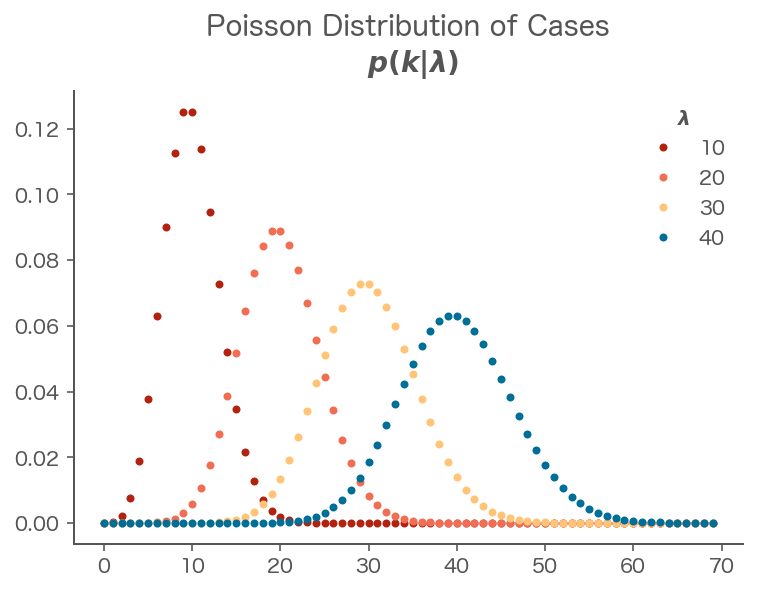

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

ポアソン分布では 1日に 𝜆のケースがあると考えれば 偶然性に基づく多少の変動をプラスマイナスしても おそらくそれだけの数が得られるということです

しかし、私たちの場合は、𝑘 のケースがあったことがわかっているので、どのような値が最も可能性が高いのかを知る必要があります。そのためには、𝜆を変化させながら𝑘 を固定します。__これを尤度関数といいます。__

たとえば、𝑘=20 の新しいケースを観測して、それぞれの 𝜆 がどのくらいの確率であるかを知りたいとします。

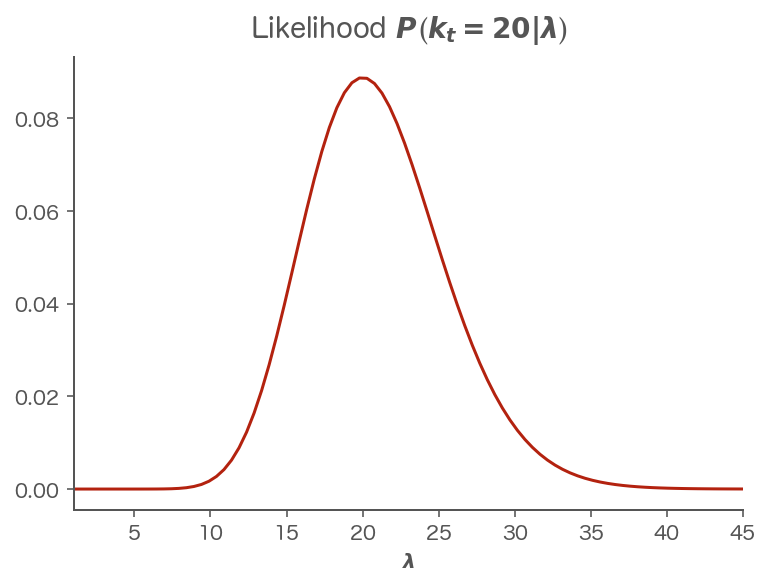

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

これによると、20件のケースを見た場合、𝜆の値が最も可能性が高いのは（驚くことではありませんが）20だということになります。しかし、確実ではありません。 ラムダが 21 か 17 で、たまたまそれだけで 20 の新しいケースを見た可能性もあります。𝜆が40だったのに20を見たということはあり得ないとも書いてあります。

凄いですね。𝜆によってパラメタライズされた 𝑃(𝜆𝑡|𝑘𝑡) がありますが、𝑅𝑡によってパラメタライズされた 𝑃(𝑘𝑡|𝑅𝑡) を探していました。𝜆と𝑅𝑡の関係を知る必要があります。

### $\lambda$ と $R_t$ を関係づける

__𝑅𝑡 と 𝜆 の間につながりがあることに気づくことが、これを機能させるための重要な洞察である。__その導出はこのノートの範囲を超えていますが、ここにあります。

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

ここで、 𝛾 は直列間隔の逆数（COVID19 では約 7 日間）である。前日の新しい症例数をすべて知っているので、𝑘 を固定し、𝑅𝑡 を変化させることで、尤度関数をポアソンパラメータ化したものに再構成することができます。

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### 尤度関数の評価

例題を続けるために、新しい症例数𝑘 のサンプルを想像してみよう。𝑅𝑡 の値がそれぞれの日に異なる可能性は？

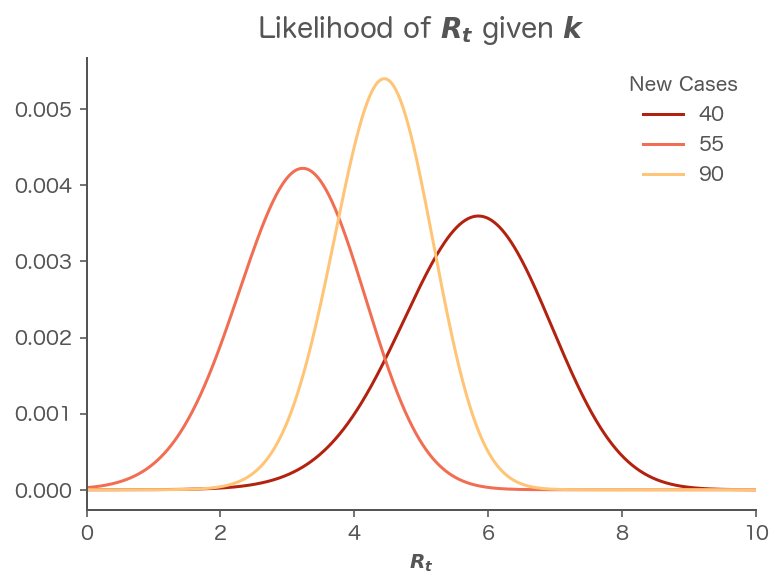

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

𝑅𝑡については、それぞれの日ごとに独立した推測をしていることがわかります。目標は、過去の日についての情報を現在の日と組み合わせることです。これを行うには、ベイズの定理を使用します。

### ベイズ更新の実行

ベイズ更新を実行するには、尤度に事前分布（ガウス更新なしの前日の尤度）を乗算して、事後分布を得る必要があります。各連続した日の累積積を使ってみましょう。

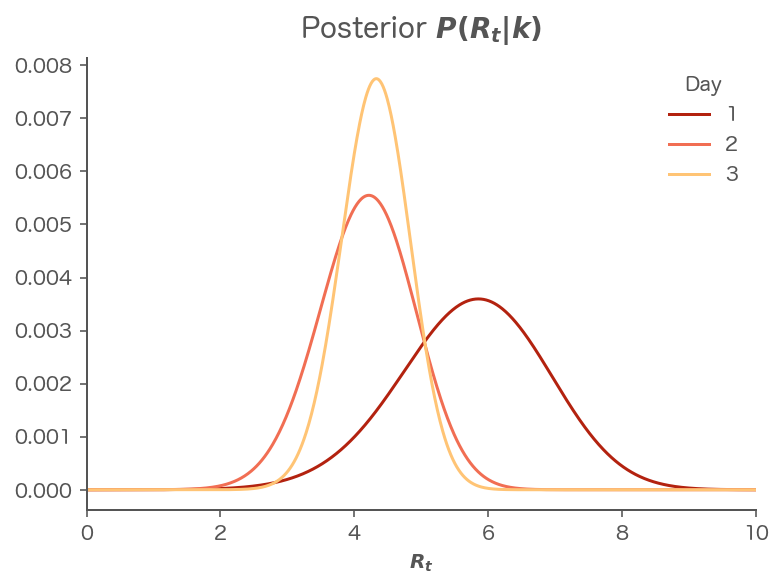

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

1日目に我々の事後処理が上から見た1日目の尤度と どうやって一致するか注目してください？これは、その日以外の情報がないからです。しかし、2日目の情報を使用して事前分布を更新すると、曲線が左に移動しているのがわかりますが、上から見た2日目の尤度ほど左には移動していません。これは、ベイズ更新が両方の日の情報を使用し、2つの日を効果的に平均化するからです。3日目の尤度は他の2つの間にあるので、少し右にシフトしていますが、より重要なのは、分布が狭くなっていることです。私たちは、𝑅𝑡 の真価を確信するようになってきています。

これらの事後分布から、"毎日の$R_t$の最も可能性の高い値は何か？"といった重要な質問に答えることができます。

In [7]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

また、𝑅𝑡 の最高密度区間を求めることができる。

In [8]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


最後に、𝑅𝑡 の最も可能性の高い値と HDI を時間の経過とともにプロットすることができます。これは、私たちの信念が日を追うごとにどのように変化していくかを示しているので、最も有用な表現である。

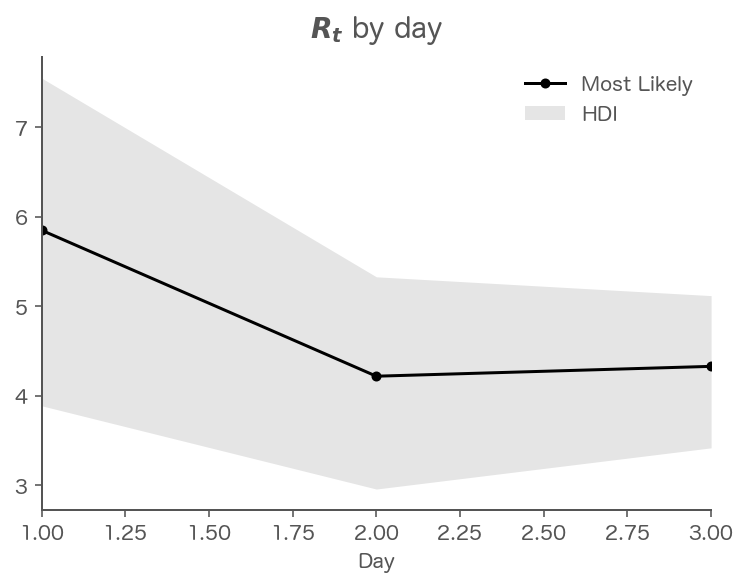

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

𝑅𝑡 の最も可能性の高い値は時間の経過とともに変化し、時間の経過とともに𝑅𝑡 の真の値が確信できるようになるにつれて、密度の高い区間が狭くなることがわかります。なお、今回は4日間の履歴しかないため、このサンプルにはこのプロセスを適用していない。しかし、次に、このプロセスが必要とされる実世界での応用例を見てみよう。

## 日本データへの適用

### 準備

日本のケースデータを読み込み、データを整形する (データ: https://jag-japan.com/covid19map-readme)

In [4]:
url = 'https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'

# 受診都道府県の人数が東京都公式新型コロナウイルス対策サイトの感染者数と一致している
data = pd.read_csv(url,
                     usecols=['確定日', '受診都道府県', '人数'],
                     parse_dates=['確定日'],
#                      index_col=['確定日', '受診都道府県'],
#                      squeeze=True
                    ).sort_index()

# FILTERED_REGION_CODES = ['中部国際空港', '成田空港', '羽田空港', '関西国際空港']
PREF = ['東京都', '三重県', '京都府', '佐賀県', '兵庫県', '北海道', '千葉県', '和歌山県', '埼玉県', '大分県', '大阪府', '奈良県', '宮城県', '宮崎県', '富山県', '山口県', '山形県', '山梨県', '岐阜県', '岡山県', '島根県', '広島県', '徳島県', '愛媛県', '愛知県', '新潟県', '栃木県', '沖縄県', '滋賀県', '熊本県', '石川県', '神奈川県', '福井県', '福岡県', '福島県', '秋田県', '群馬県', '茨城県', '長崎県', '長野県', '青森県', '静岡県', '香川県', '高知県', '鳥取県', '鹿児島県']

In [6]:
df_all = pd.DataFrame()

for pref in PREF:
    ds = data.groupby(['確定日', '受診都道府県'], as_index=False).sum()
    dsp = ds[ds['受診都道府県']==pref]
    dsp['累積人数'] = dsp['人数'].cumsum()
    dsp = dsp.rename(columns={'確定日': 'date', '受診都道府県': 'state'})
    dspi = dsp.set_index(['state', 'date'])
    df_all = pd.concat([df_all, dspi])

states = df_all['累積人数']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


州を見て、毎日のケース数が一定の場合に分析を開始する必要があります。最後に新規ケースが0件だった日を見つけて、その翌日から分析を開始します。

また、ケースの報告は、テストのバックログなどに基づいて非常に不規則です。できる限り「真の」データの最良のビューを得るために、時系列にガウスフィルタを適用しました。これは明らかに任意の選択ですが、現実世界のプロセスは実際の報告ほど確率的ではないと想像できるでしょう。


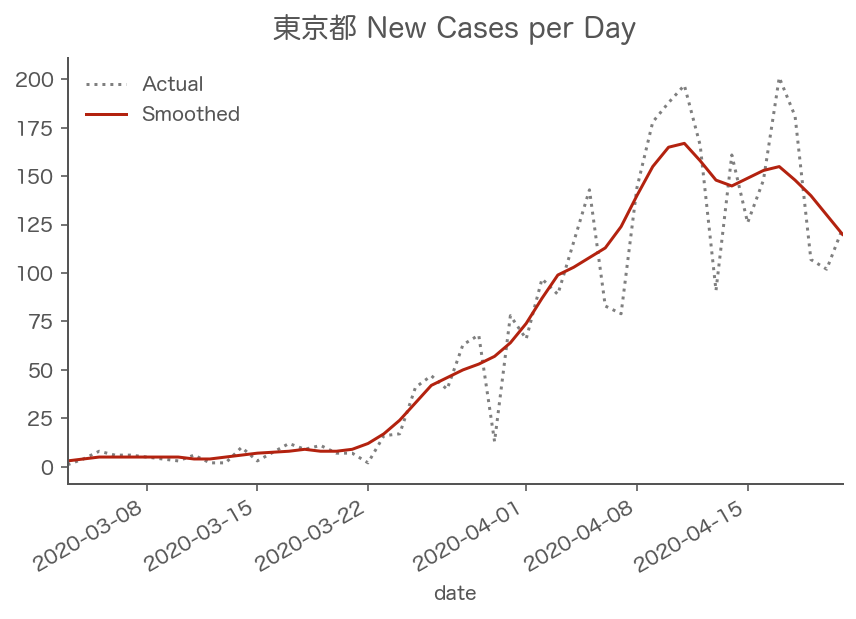

In [26]:
state_name = '東京都'

def prepare_cases(cases, cutoff=3):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

### アルゴリズムの実行

#### $P(R_t|R_{t-1})$のためのガウス関数の$\sigma$の選択

> 注意: 以下のプロセスで正しい𝜎の値を選んだことを信頼しているならば、このセクションは読み飛ばしても大丈夫です。そうでなければ、読み進めてください。

オリジナルのアプローチは、単に昨日の事後処理を今日の事後処理として選択するだけである。直感的ではあるが、そうすることで、𝑅𝑡 の値が昨日から変化している可能性が高いという我々の確信を許容することはできない。その変化を許容するために、我々はある程度の標準偏差 𝜎 を持つ事前分布にガウスノイズを適用する。𝜎が高ければ高いほどノイズが多く、𝑅𝑡の値が毎日ドリフトすることを期待することになる。興味深いことに、ノイズにノイズを反復的に適用することは、遠方の事後分布が自然に減衰することを意味します。このアプローチはwindowingの効果と似ていますが、よりロバストで、私の以前のアプローチのように一定時間が経過した後に任意に事後予測を忘れてしまうことはありません。具体的には、windowingでは、周囲の𝑤 日のケースを説明するような固定の𝑅𝑡 を各時刻 𝑡 で計算していたのに対し、新しいアプローチでは、𝑅𝑡 が毎日 𝜎 程度変動すると仮定して、すべてのケースを説明するような一連の 𝑅𝑡 の値を計算しています。

しかし、それでも恣意的な選択がある： 𝜎はどうあるべきか？アダム・ラーラーは 最尤度のプロセスを使って 選択を知らせることができると指摘しています それがどのように機能するかを説明します。

最尤度は、データを見る可能性を最大化するaを選択したいと言います： 𝑃(𝑘|𝜎) 𝜎は固定値なので、表記から外しておきましょう。

𝑃(𝑘)=𝑃(𝑘0,𝑘1,...𝑘𝑡)=𝑃(𝑘0)𝑃(𝑘1)...𝑃(𝑘𝑡)なので
を定義する必要があります 𝑃(𝑘𝑡)。これがベイズ則の分母であることがわかります。

$$P(R_t|k_t) = \frac{P(k_t|R_t)P(R_t)}{P(k_t)}$$

それを計算するために、分子は実際には𝑘 と 𝑅 の共同分布にすぎないことに気づく。

$$ P(k_t,R_t) =  P(k_t|R_t)P(R_t) $$

𝑅𝑡 にまたがる分布を限界化して、𝑃(𝑘𝑡) を求めることができる。

$$ P(k_t) = \sum_{R_{t}}{P(k_t|R_t)P(R_t)} $$

そこで、分子の分布を、𝑅𝑡 のすべての値にわたって合計すると、𝑃(𝑘𝑡) が得られる。そして、事後処理を計算しているときに、とにかくそれを計算しているので、それを別々に記録しておきます。

𝑃(𝑘)を全体的に最大化する𝜎の値を探しているので、実際には最大化したいのです。

$$\prod_{t,i}{p(k_{ti})}$$

ここで、𝑡 はすべての時間であり、𝑖 はそれぞれの州です。

小さな確率をたくさん掛け合わせているので、値の対数を取って、それらを一緒に足していく方が簡単です (そしてエラーになりにくい)。log𝑎𝑏=log𝑎+log𝑏と覚えておきましょう。そして、対数は単調増加するので、確率の対数の和を最大化することは、𝜎の任意の選択に対する非対数確率の積を最大化することと同じです。

### 周辺部を計算するための関数

事後分布を計算するには、次の手順に従います。

1. 𝜆 - 毎日のポアソン過程の予想到着率を計算します。
2. 𝑅𝑡 のすべての可能な値について、各日の尤度分布を計算する
3. 上述した𝜎weの値に基づいてプロセスマトリクスを計算する
4. 最初の日には後続を取るための前日がないので、最初の先行を計算します。
  - cdcからの情報に基づいて我々は平均7とガンマを選択します。
5. 1日目から最後まで、以下のようにループします。
  - 昨日の先行値にガウス分布を適用して先行値を計算します。
  - この先行値とステップ2で計算した尤度を掛け合わせてベイズの法則を適用します。
  - データの確率で割る(これもベイズの法則)

In [27]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

### 結果

下には、事後分布の毎日（行）が同時にプロットされています。事後分布は、あまり自信を持たずに始まり（幅が広い）、𝑅𝑡 の真値について徐々に自信を持つようになる（幅が狭くなる）。

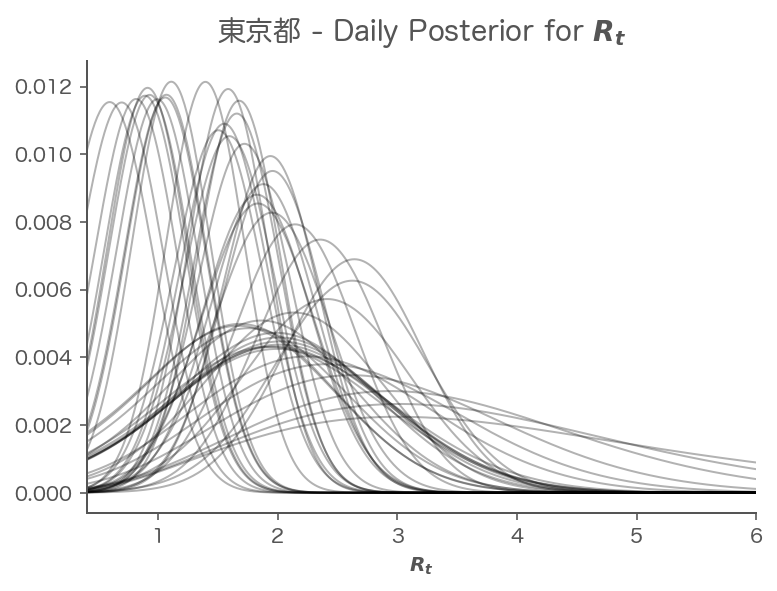

In [28]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

### 信頼できる間隔での時間領域でのプロット

我々の結果には不確実性が含まれているので、𝑅𝑡 の最も可能性の高い値を、その最も密度の高い区間とともに表示できるようにしたいと考えています。

In [29]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-04-17,1.07,0.47,1.59
2020-04-18,0.93,0.32,1.44
2020-04-19,0.81,0.24,1.35
2020-04-20,0.69,0.13,1.22
2020-04-21,0.59,0.02,1.08


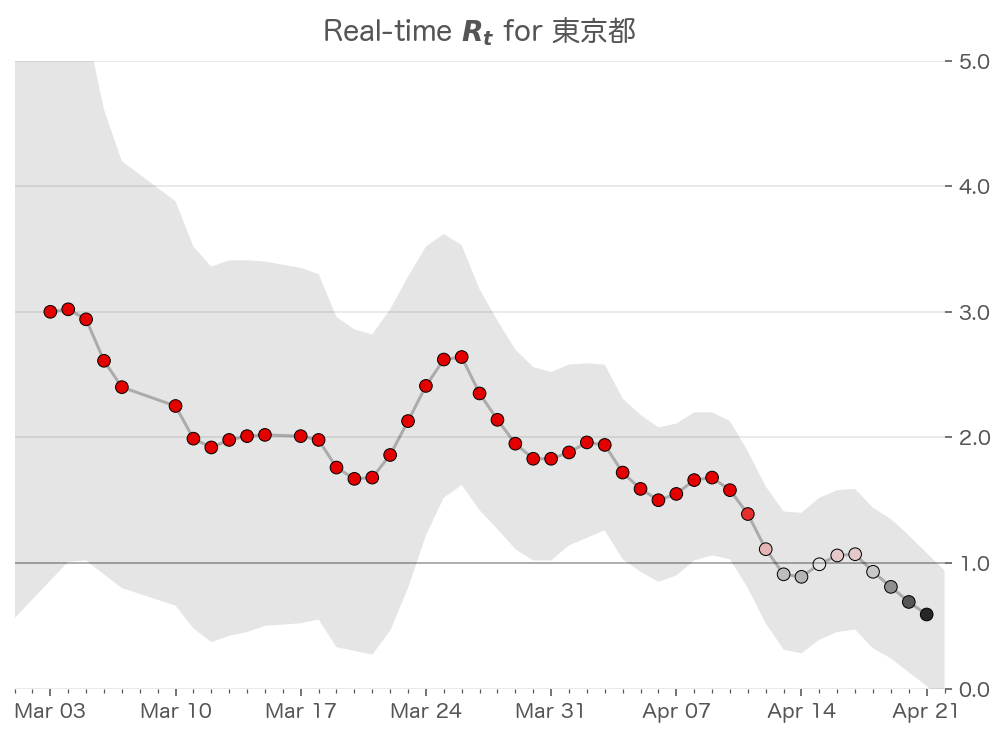

In [31]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### 最適な𝜎の選択

前節では最適な𝜎を選ぶことを説明しましたが、値を想定しただけでした。しかし，各状態を任意のシグマで評価できるようになったので，最適な 𝜎を選択するためのツールを手に入れることができます．

上では、データ 𝑃(𝑘) の尤度を最大にする 𝜎 の値を選ぶと述べました。我々はどの状態にもオーバーフィットしたくないので、すべての状態で 𝑃(𝑘) を最大化するシグマを選びます。これを行うには、シグマの各値について状態ごとのすべての対数尤度を加算し、最大値を選択します。

>    注意: これには時間がかかります!


In [32]:
sigmas = np.linspace(1/20, 1, 20)

targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='state'):
    
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=0)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=10)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.


すべての対数尤度が得られたので、州ごとのシグマの各値を合計し、それをグラフ化し、最大値を選択することができます。

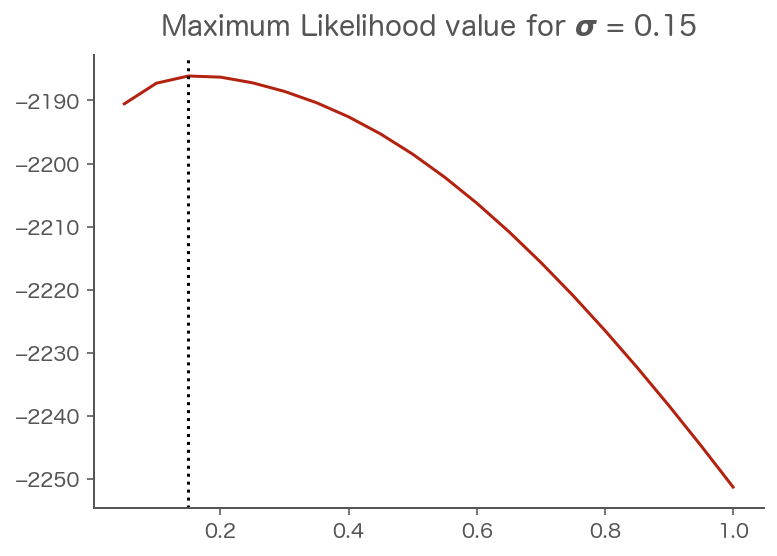

In [33]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

### 最終的な結果をまとめる

最適な𝜎を選択したことを考えると、各状態についてその値の𝜎に対応する事前計算された事後処理をつかみましょう。また、90%と50%の最高密度区間（これは少し時間がかかります）と最も可能性の高い値を計算しましょう。

In [34]:
final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

Done.


### 全国のプロット

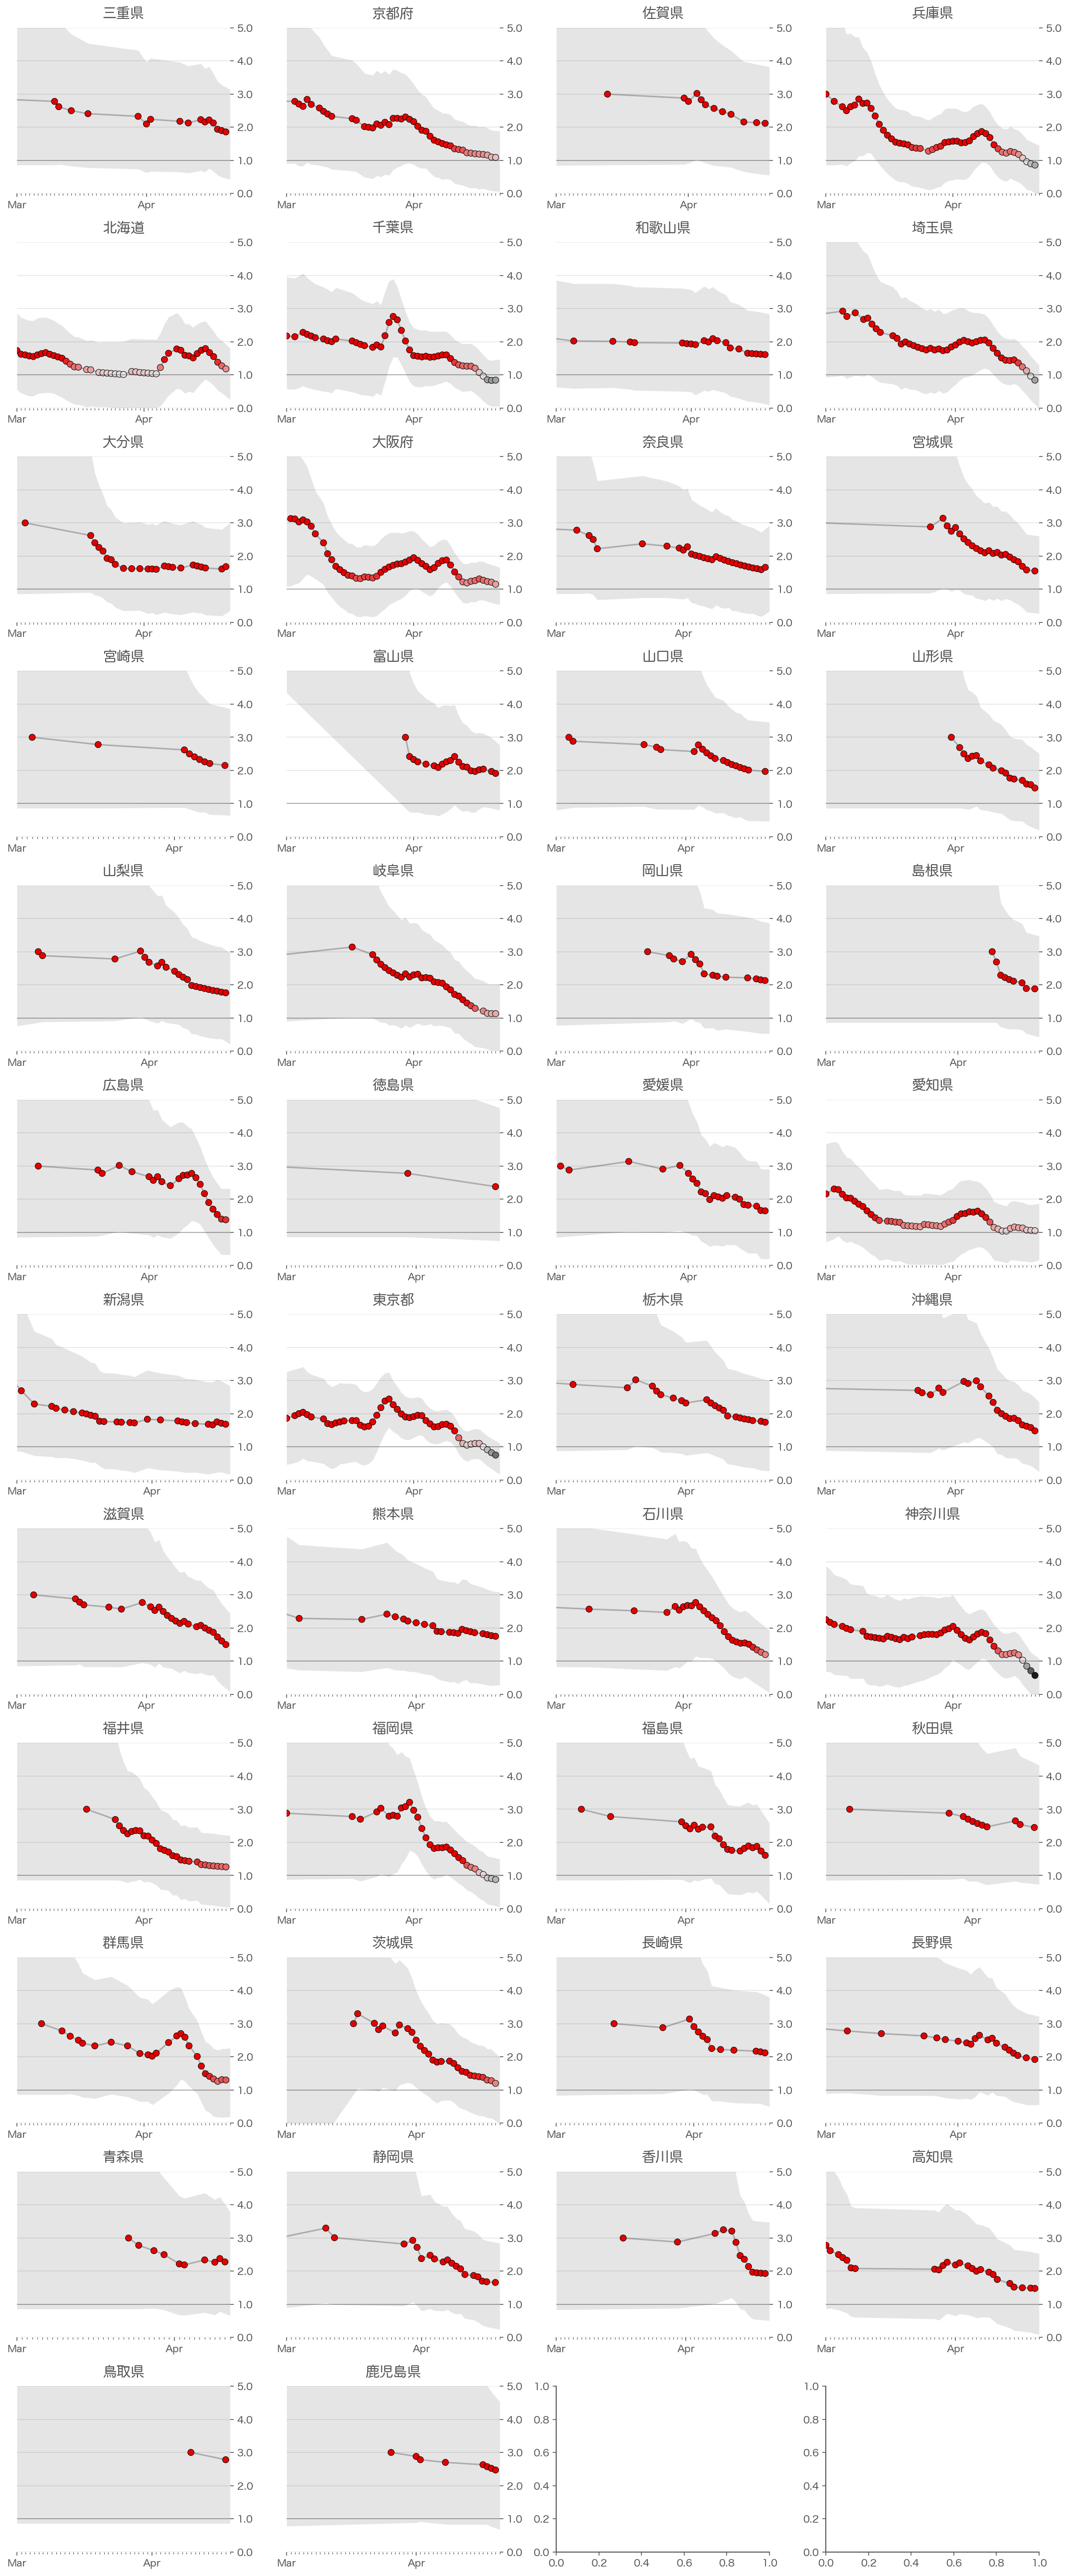

In [35]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

### データをCSVにエクスポート

In [37]:
# Uncomment the following line if you'd like to export the data
final_results.to_csv('data/rt_japan.csv')

### 以下草稿

In [ ]:
# As of 4/12
no_lockdown = [
    'North Dakota', 'ND',
    'South Dakota', 'SD',
    'Nebraska', 'NB',
    'Iowa', 'IA',
    'Arkansas','AR'
]
partial_lockdown = [
    'Utah', 'UT',
    'Wyoming', 'WY',
    'Oklahoma', 'OK',
    'Massachusetts', 'MA'
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [ ]:
final_results

In [ ]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

In [ ]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

In [ ]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

In [ ]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()

In [ ]:
df3stk = dataf3sumtokyo.rename(columns={'確定日': 'date', '受診都道府県': 'state'})
df3stki = df3stk.set_index(['state', 'date'])
# df3stki
states = df3stki['累積人数']
states

In [7]:
# data2.groupby(['居住都道府県']).sum()
# data.groupby(['受診都道府県']).sum()